# Logistic Regression
First, we will build a logistic regression model without tuning it and get that accuracy as a baseline. After that simple approach, we will tune the regularization strength with cross-validated grid-search.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the data sets, train set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-train-features.npz") as npz_file:
    hl_tr_features = npz_file["features"]
    tr_labels = npz_file["labels"]
    
print("train features shape:", hl_tr_features.shape)
print("train labels shape:", tr_labels.shape)

train features shape: (280, 1280)
train labels shape: (280,)


In [3]:
# validation set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-valid-features.npz") as npz_file:
    hl_val_features = npz_file["features"]
    val_labels = npz_file["labels"]
    
print("validation features shape:", hl_val_features.shape)
print("validation labels shape:", val_labels.shape)

validation features shape: (139, 1280)
validation labels shape: (139,)


In [4]:
# test set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-test-features.npz") as npz_file:
    hl_te_features = npz_file["features"]
    te_labels = npz_file["labels"]
    
print("test features shape:", hl_te_features.shape)
print("test labels shape:", hl_te_features.shape)

test features shape: (50, 1280)
test labels shape: (50, 1280)


Because we aren't tuning the model in the simple baseline case, and we will use the cross-validation grid search approach for the regularization strength in the tuned model, I will combine the train and validation set to have a larger data pool to train on.

In [5]:
# combine train and validation set
train_features = np.append(hl_tr_features, hl_val_features, axis = 0)
train_labels = np.append(tr_labels, val_labels, axis = 0)

print("combined train features shape:", train_features.shape)
print("combined train labels shape:", train_labels.shape)

combined train features shape: (419, 1280)
combined train labels shape: (419,)


At first, we will fit a logistic regression with the One-vs-Rest multi class function as we have 6 possible classes. In the OvR approach, each class votes against all other to decide the positive class.

In [6]:
from sklearn.linear_model import LogisticRegression

# create object
logreg = LogisticRegression(multi_class = "ovr", solver = "liblinear")

# fit training data
logreg.fit(train_features, train_labels)

# get accuracy
logreg_accuracy = logreg.score(hl_te_features, te_labels)
print("logreg base test accuracy:", logreg_accuracy)

logreg base test accuracy: 0.92


At this point, the accuracy already looks much better than the one from the decision tree models, and we haven't even tuned anything.

Let's just quickly check at this point whether the softmax multiclass would work even better

In [7]:
# create object
logreg2 = LogisticRegression(multi_class = "multinomial", solver = "saga", max_iter = 1000)

# fit object with training data
logreg2.fit(train_features, train_labels)

# get accuracy
logreg2_accuracy = logreg2.score(hl_te_features, te_labels)
print("logreg accuracy with softmax:", logreg2_accuracy)

logreg accuracy with softmax: 0.92


We had to increase the maximum iteration, but the accuracy is still the same. Because of this, I will continue using the OvR approach

Now search for the best regularization strength `C`. 

In the `RidgeRegression` approach, we control the regularization with a parameter called `alpha`. 

$$
loss + \alpha * penalization
$$

Here, we control the weight of the loss function by multiplying it by a $C$ parameter.

$$
C * loss + penalization
$$

A high $C$ means that we decrease the regularization strength by increasing C

In [8]:
from sklearn.model_selection import GridSearchCV

# create new LogisticRegression object
logreg_gridCV = LogisticRegression(multi_class = "ovr", solver = "liblinear")

# define the grid
grid = {
    "C": np.logspace(-4, 4, num = 50) # pass 50 values between 10^-4 and 10^4
}

# create gridCV object
gridCV = GridSearchCV(logreg_gridCV, # multi_class = "ovr", solver = "liblinear"
                     param_grid = grid,
                     n_jobs = -1, # use parallel cores
                     cv = 10, # use stratified 10-fold cross validation
                     verbose = 1, # get progress updates
                     return_train_score = True # get train scores aswell
                     )

In [9]:
# fit the gridCV object with training data
gridCV.fit(train_features, train_labels)

# get all available results
gridCV.cv_results_.keys()

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

What have we done here:
* Evaluated 50 different `C` values on 10 different stratified cross-validation splits
    * Hence, in total we had 500 fits
* The evaluation took place on 10 different folds of the train set, which in effect provided artificially created validation sets
* We then averaged the 10 folds, resulting in 50 results

Let's present the results in a dataframe

In [10]:
# present results in a df
gridCV_results = pd.DataFrame({
    "param_C": gridCV.cv_results_["param_C"],
    "mean_test_score": gridCV.cv_results_["mean_test_score"],
    "std_test_score": gridCV.cv_results_["std_test_score"],
    "mean_train_score": gridCV.cv_results_["mean_train_score"],
    "std_train_score": gridCV.cv_results_["std_train_score"]
    
})

# sort df for highest test score
sorted_gridCV = gridCV_results.sort_values(by = "mean_test_score", ascending = False)
sorted_gridCV.head()

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
14,0.019307,0.909308,0.030118,0.993107,0.001291
11,0.00625055,0.909308,0.028125,0.967386,0.003548
16,0.0409492,0.906921,0.031502,0.995226,0.001063
37,109.854,0.906921,0.028004,1.000000,0.000000
19,0.126486,0.906921,0.031502,1.000000,0.000000


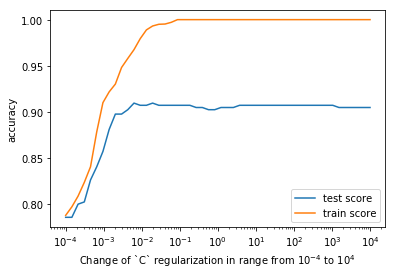

In [11]:
# let's plot the results
plt.semilogx(gridCV.cv_results_["param_C"], gridCV.cv_results_["mean_test_score"], label = "test score")
plt.semilogx(gridCV.cv_results_["param_C"], gridCV.cv_results_["mean_train_score"], label = "train score")
plt.xlabel("Change of `C` regularization in range from $10^{-4}$ to $10^4$")
plt.ylabel("accuracy")
plt.legend()
plt.show()

What we can observe here is that our model is constantly overfitting during all ranges of `C` greater than $~10^{-3}$. When `C` is smaller than $0.001$ - i.e. increasing the regularization - the model becomes too rigid and starts to underfit.

Furthermore, there is no difference between having the baseline model with `C = 1` (or $10^0$) and large `C` values like `C = 10000`. The model is overfitting widely in both cases.

However, when we closely compare the values in the DataFrame above, we can see that the second row, i.e. `C = 0.006` reaches the same average test score as our "highest accuracy" result, but the model doesn't overfit as much. There seems to be an optimum for us in these ranges.

For the final accuracy metric on the actual test set, I will choose a `C` value of $10^{-2.5}$ as the test score in that range is in the ~90% accuracy range but the model isn't overfitting too much.

In [12]:
# create object
logreg3 = LogisticRegression(C = 10**(-2.5), solver = "liblinear", multi_class = "ovr")

# fit object
logreg3.fit(train_features, train_labels)

# get accuracy on test set
logreg3_accuracy = logreg3.score(hl_te_features, te_labels)
print("tuned logreg test accuracy:", logreg3_accuracy)
print("tuned logreg train accuracy:", logreg3.score(train_features, train_labels))

tuned logreg test accuracy: 0.96
tuned logreg train accuracy: 0.9498806682577565


What we can see here is really interesting, because it seems like we have found a `C` value which regularizes the model fitting process enough to prevent overfitting while still allowing enough learning ability. As a result, we get a model that generalizes better on the actual test set than on the training set itself. 

Usually, we should have been able to see this in either the graph or the DataFrame, but I think that the constant averaging process over 10 folds as well as the stratification balancing might have actually hurt the observation of the model performance. 
___
I will use this fit to make the predictions for the 10 images

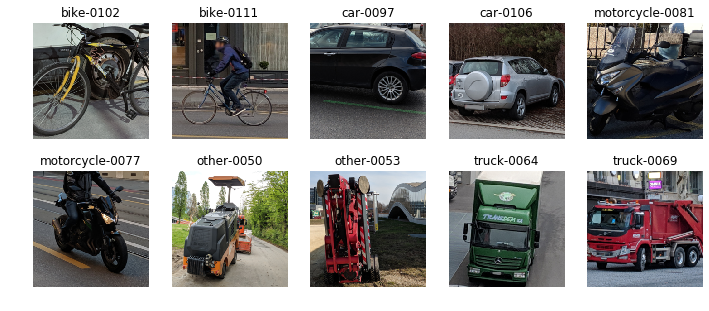

In [13]:
from PIL import Image

# pick 10 images to plot
ten_imgs = ["/Users/Ingo/Python Files/Course-project4/swissroads/test/bike/bike-0102.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/bike/bike-0111.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/car/car-0097.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/car/car-0106.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/motorcycle/motorcycle-0081.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/motorcycle/motorcycle-0077.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/other/other-0050.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/other/other-0053.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/truck/truck-0064.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/truck/truck-0069.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/van/van-0042.png",
           "/Users/Ingo/Python Files/Course-project4/swissroads/test/van/van-0039.png"]

# save titles to use as index in DataFrame
img_titles = []

# plot the 10 imgs
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (12, 5))

for img_to_plot, ax in zip(ten_imgs, axes.flatten()):
    img = Image.open(img_to_plot)
    ax.imshow(img)
    ax.axis("off")
    
    # create title as split of directory name
    title_split = img_to_plot.split("/")[-1] # get everything of the split after the last "/"
    title_split = title_split[:-4] # remove ".png"
    img_titles.append(title_split)
    ax.set_title(title_split) 
    

plt.show()

Now we will use our `logreg3` estimator to make predictions based on the high-level features of those images. The results will be presented in a DataFrame

In [14]:
# get indices of the ten images in hl_te_features
# bike indices until 11, car until 22, motorcycle until 31, other until 37, truck until 44
imgs_indices = [2, 11, 12, 21, 27, 23, 33, 36, 38, 43]

# use logreg3 estimator which is already tuned with optimal C


# store results
preds_results = []
class_pred_results = []
true_class_results = []

# iterate through chosen image indices
for idx in imgs_indices:
    pred_proba = np.round(logreg3.predict_proba(hl_te_features[idx][np.newaxis, :]), 2) # round values
    class_pred = logreg3.predict(hl_te_features[idx][np.newaxis, :]).astype(int) # classes have int values
    true_class = te_labels[idx].astype(int) # labels have int values
    
    preds_results.append(pred_proba)
    class_pred_results.append(class_pred)
    true_class_results.append(true_class)
    
# get preds_results into an array, reshape it because list was 3-dimensional
preds_results = np.array(preds_results).reshape([10, 6])

# flatten class_pred_results
class_pred_results = [preds for class_preds in class_pred_results for preds in class_preds]

# create df, append all data
logreg3_results = pd.DataFrame(
    preds_results, columns = ["bike", "car", "motorcycle", "other", "truck", "van"],
    index = img_titles
)

# append class predictions and true classes for easier evaluation
logreg3_results["class preds"] = class_pred_results
logreg3_results["true classes"] = true_class_results
logreg3_results

,bike,car,motorcycle,other,truck,van,class preds,true classes
bike-0102,0.89,0.02,0.05,0.02,0.01,0.01,0,0
bike-0111,0.81,0.03,0.05,0.05,0.04,0.03,0,0
car-0097,0.04,0.70,0.04,0.05,0.04,0.13,1,1
car-0106,0.03,0.77,0.04,0.06,0.03,0.07,1,1
motorcycle-0081,0.03,0.05,0.74,0.11,0.05,0.03,2,2
motorcycle-0077,0.10,0.02,0.81,0.04,0.02,0.01,2,2
other-0050,0.05,0.08,0.14,0.48,0.22,0.04,3,3
other-0053,0.10,0.06,0.13,0.59,0.11,0.01,3,3
truck-0064,0.05,0.06,0.12,0.27,0.34,0.16,4,4
truck-0069,0.05,0.08,0.04,0.24,0.54,0.06,4,4


With a tuned `C` we get results that match (in this example) all images to the correct class. The probabilities are mostly unambiguous. 6 images have probabilities over 70% for the correct class, 3 images have probabilities in the range of 50%-60%, and only 1 image has really spread out probabilities with 4 classes between 12% and 34%. Nevertheless, all classes have been classified correctly here.

The fact that we don't have probabilities of around 99%+ for one class can be interpreted as a sign of not having an overfitted model - although to definitely conclude this, we'd need to inspect train and test accuracies. If both train and test model had accuracies of 99%+, we would have really good model and not an overfitting one.

### Change of Probabilities while `C` changes
I will now create two more logistic regressions estimators, fit them, and recreate the above DataFrame to see how different `C` levels change the probabilities

In [15]:
# create object with small C
logreg4 = LogisticRegression(C = 10**(-4), # small C --> very strong regulation, model will underfit
                            multi_class = "ovr",
                            solver = "liblinear")

# store results
preds_results = []
class_pred_results = []
true_class_results = []

# fit with training data
logreg4.fit(train_features, train_labels)

for idx in imgs_indices:
    pred_proba = np.round(logreg4.predict_proba(hl_te_features[idx][np.newaxis, :]), 2)
    class_pred = logreg4.predict(hl_te_features[idx][np.newaxis, :]).astype(int)
    true_class = te_labels[idx].astype(int)
    
    preds_results.append(pred_proba)
    class_pred_results.append(class_pred)
    true_class_results.append(true_class)
    
# get preds_results into an array, reshape it
preds_results = np.array(preds_results).reshape([10, 6])

# flatten class_pred_results
class_pred_results = [preds for class_preds in class_pred_results for preds in class_preds]

# create df, append all data
logreg4_results = pd.DataFrame(
    preds_results, columns = ["bike", "car", "motorcycle", "other", "truck", "van"],
    index = img_titles
)

logreg4_results["class preds"] = class_pred_results
logreg4_results["true classes"] = true_class_results
logreg4_results

,bike,car,motorcycle,other,truck,van,class preds,true classes
bike-0102,0.32,0.14,0.17,0.13,0.13,0.12,0,0
bike-0111,0.28,0.15,0.16,0.14,0.14,0.13,0,0
car-0097,0.16,0.25,0.15,0.14,0.15,0.15,1,1
car-0106,0.15,0.26,0.15,0.14,0.15,0.14,1,1
motorcycle-0081,0.16,0.16,0.24,0.15,0.15,0.13,2,2
motorcycle-0077,0.20,0.15,0.25,0.14,0.13,0.12,2,2
other-0050,0.17,0.18,0.18,0.17,0.17,0.13,2,3
other-0053,0.19,0.17,0.18,0.17,0.16,0.12,0,3
truck-0064,0.16,0.18,0.17,0.16,0.18,0.15,4,4
truck-0069,0.16,0.17,0.15,0.17,0.20,0.15,4,4


This model is underfitting because we have a small `C`, which means that we have a strong regularization.
Even though only 2 images have been misclassified, the maximum probability for any class in any image is 32%. This means that the model couldn't learn well from our training data because it is too rigid in its learning approach. As a consequence, it recognizes features from any class in any image, leading to very spread out probabilities, and, as a result, to picking a class not very "confidently".

If images are easily recognizable, i.e. belonging clearly to a certain class like bikes, we still get good results. As soon as the images are starting to look similar to other classes - like "other" and "truck", we get almost random results with each class having a probability between 12% and 20%. The estimators aren't able to learn the specifics of each class. 

In [16]:
# create object with large C (as we saw, there is no difference between C = 1 and C = 10000)
logreg5 = LogisticRegression(C = 10**(4), # large C --> no regularization, model will overfit
                            multi_class = "ovr",
                            solver = "liblinear")

# store results
preds_results = []
class_pred_results = []
true_class_results = []

# fit with training data
logreg5.fit(train_features, train_labels)

for idx in imgs_indices:
    pred_proba = np.round(logreg5.predict_proba(hl_te_features[idx][np.newaxis, :]), 2)
    class_pred = logreg5.predict(hl_te_features[idx][np.newaxis, :]).astype(int)
    true_class = te_labels[idx].astype(int)
    
    preds_results.append(pred_proba)
    class_pred_results.append(class_pred)
    true_class_results.append(true_class)
    
# get preds_results into an array, reshape it
preds_results = np.array(preds_results).reshape([10, 6])

# flatten class_pred_results
class_pred_results = [preds for class_preds in class_pred_results for preds in class_preds]

# create df, append all data
logreg5_results = pd.DataFrame(
    preds_results, columns = ["bike", "car", "motorcycle", "other", "truck", "van"],
    index = img_titles
)

logreg5_results["class preds"] = class_pred_results
logreg5_results["true classes"] = true_class_results
logreg5_results

,bike,car,motorcycle,other,truck,van,class preds,true classes
bike-0102,1.0,0.0,0.0,0.00,0.00,0.00,0,0
bike-0111,1.0,0.0,0.0,0.00,0.00,0.00,0,0
car-0097,0.0,1.0,0.0,0.00,0.00,0.00,1,1
car-0106,0.0,1.0,0.0,0.00,0.00,0.00,1,1
motorcycle-0081,0.0,0.0,1.0,0.00,0.00,0.00,2,2
motorcycle-0077,0.0,0.0,1.0,0.00,0.00,0.00,2,2
other-0050,0.0,0.0,0.0,1.00,0.00,0.00,3,3
other-0053,0.0,0.0,0.0,1.00,0.00,0.00,3,3
truck-0064,0.0,0.0,0.0,0.82,0.16,0.02,3,4
truck-0069,0.0,0.0,0.0,0.00,1.00,0.00,4,4


We can see here a clear case of an overfitted model, where probabilities for classes go up to 1. In 9 out of 10 images, we choose our model with a probability of 100% for the relevant class, and are correct in 9 out of 10 cases.

Even in the case where we are incorrect, we are incorrect in a "confident" way in which we pick the wrong class with an 82% probability to be that incorrect class. 

The model learns too much from features and isn't able to generalize well. If the features match, we classify the class with very high probabilities, but the accuracy on new images doesn't rise equally. In some sense, we desensitize the estimator. As a result, we decisevly choose classes, but are also somtimes desicevly wrong.

In [17]:
# create a DataFrame to store our the test accuracies and save the file
save_df = pd.DataFrame({
    "model": ["logistic"],
    "test_accuracy": [logreg3_accuracy]
})

# save the df
save_df.to_csv("/Users/Ingo/Python Files/Course-project4/04_logistic-regression.csv",
              index = False)